In [191]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Retina 
%config InlineBackend.figure_format = 'retina'

In [192]:
def create_hash_table(X_train, P, seed=35):
    np.random.seed(seed)
    R = np.random.randn(X_train.shape[1] + 1, P)  # +1 for bias term
    X_train_aug = np.hstack([np.ones((X_train.shape[0], 1)), X_train])  # Augment with bias
    H_table = np.sign(X_train_aug @ R)
    return H_table, R, X_train_aug

In [195]:
import numpy as np

def find_knn_lsh(X_test_point, X_train, R, H_table, k=3):
    """
    Find k-nearest neighbors for a single data point using LSH.

    Parameters:
    - X_test_point (numpy.ndarray): Single test point of shape (D,).
    - X_train (numpy.ndarray): Training data of shape (N_train, D).
    - R (numpy.ndarray): Random projection matrix of shape (D+1, P).
    - H_table (numpy.ndarray): Hash table for the training data.
    - k (int): Number of nearest neighbors to find.

    Returns:
    - knn_indices (list): Indices of the k-nearest neighbors in the training data.
    - knn_distances (list): Distances of the k-nearest neighbors.
    """
    # Augment the test data point with a bias term
    X_test_aug = np.hstack([1, X_test_point])  # Augment with bias term
    
    # Compute the hash for the test point
    hash = np.sign(X_test_aug @ R)
    
    # Find indices in the hash table that match the hash
    matching_indices = np.where((H_table == hash).all(axis=1))[0]
    
    if len(matching_indices) == 0:
        print("No points found in the same hash bucket.")
        return [], []
    
    # Extract matching points and compute distances
    hash_points = X_train[matching_indices]
    distances = np.linalg.norm(hash_points - X_test_point, axis=1)
    
    # Get the indices of the k closest points
    closest_indices = np.argsort(distances)[:k]
    knn_indices = matching_indices[closest_indices]
    knn_distances = distances[closest_indices]
    
    return knn_indices, knn_distances


In [193]:
# Generate synthetic dataset
np.random.seed(9)
X_train = 10*np.random.rand(100, 2)  # 100 training points in 2D
X_test_point = (5.5,8)  # A single test point
P = 10  # Number of hash functions (projections)

# Create hash table for training data
H_table, R, X_train_aug = create_hash_table(X_train, P)

# Find k-nearest neighbors for the test point
k = 5
knn_indices, knn_distances = find_knn_lsh(X_test_point, X_train, R, H_table, k)

# Print results
print("Test Point:", X_test_point)
print(f"{k} Nearest Neighbors Indices:", knn_indices)
print(f"{k} Nearest Neighbors Distances:", knn_distances)

from sklearn.neighbors import NearestNeighbors

# Brute force k-NN using sklearn
nbrs = NearestNeighbors(n_neighbors=k, algorithm='brute').fit(X_train)
distances, indices = nbrs.kneighbors([X_test_point])  # Find k-neighbors for the test point

# Print brute force results
print("\nBrute Force Results:")
print(f"{k} Nearest Neighbors Indices (Brute Force):", indices[0])
print(f"{k} Nearest Neighbors Distances (Brute Force):", distances[0])

Test Point: (5.5, 8)
5 Nearest Neighbors Indices: [ 9 15 30 85 96]
5 Nearest Neighbors Distances: [0.9759653  1.16656876 1.21442576 1.49303562 1.66056204]

Brute Force Results:
5 Nearest Neighbors Indices (Brute Force): [59 88  9 57 15]
5 Nearest Neighbors Distances (Brute Force): [0.46144427 0.90211513 0.9759653  1.07213944 1.16656876]


/var/folders/ws/fygh4lvs7f1f0qdwysntrxch0000gn/T/ipykernel_35932/245453449.py:15: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_train[idx, 0], X_train[idx, 1], c="green", edgecolors="black", label=f"LSH Neighbor" if i == 0 else "", s=80, marker="x")


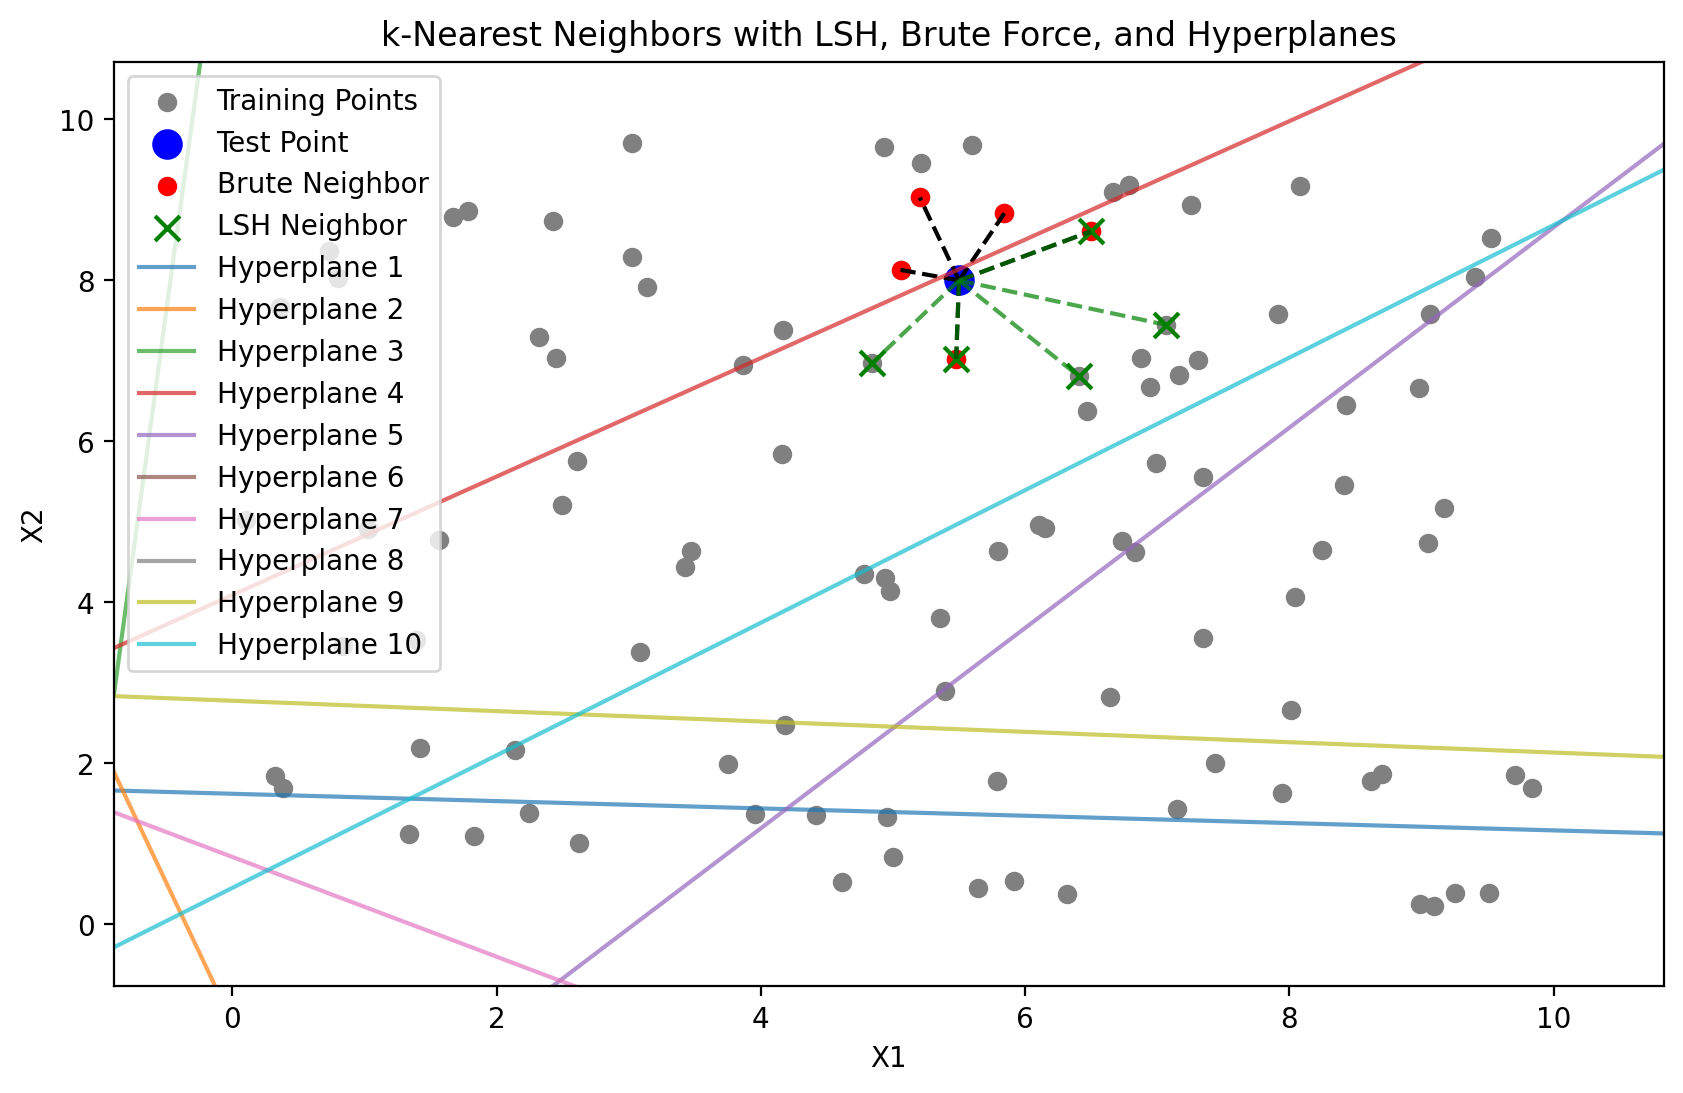

In [194]:
# Visualize results with hyperplanes
plt.figure(figsize=(10, 6))

# Plot training points and the test point
plt.scatter(X_train[:, 0], X_train[:, 1], label="Training Points", c="gray")
plt.scatter(X_test_point[0], X_test_point[1], label="Test Point", c="blue", s=100)

# Highlight brute force neighbors
for i, idx in enumerate(indices[0]):
    plt.scatter(X_train[idx, 0], X_train[idx, 1], c="red", label=f"Brute Neighbor" if i == 0 else "")
    plt.plot([X_test_point[0], X_train[idx, 0]], [X_test_point[1], X_train[idx, 1]], c="black", linestyle="--", alpha=1)

# Highlight LSH neighbors
for i, idx in enumerate(knn_indices):
    plt.scatter(X_train[idx, 0], X_train[idx, 1], c="green", edgecolors="black", label=f"LSH Neighbor" if i == 0 else "", s=80, marker="x")
    plt.plot([X_test_point[0], X_train[idx, 0]], [X_test_point[1], X_train[idx, 1]], c="green", linestyle="--", alpha=0.7)

# Plot hyperplanes
x1_range = np.linspace(min(X_train[:, 0]) - 1, max(X_train[:, 0]) + 1, 100)
for i in range(P):
    # Calculate x2 for the hyperplane equation
    x2_range = (-R[0, i] - R[1, i] * x1_range) / R[2, i]
    plt.plot(x1_range, x2_range, label=f'Hyperplane {i+1}', linestyle='-', alpha=0.7)

# Final plot details
plt.legend()
plt.title("k-Nearest Neighbors with LSH, Brute Force, and Hyperplanes")
plt.xlabel("X1")
plt.ylabel("X2")
plt.xlim(min(X_train[:, 0]) - 1, max(X_train[:, 0]) + 1)
plt.ylim(min(X_train[:, 1]) - 1, max(X_train[:, 1]) + 1)
plt.show()